# Load and save ERA5-Land Daily Aggregated data over an Area of Interest


## Requirements: 

- __Google Earth Engine account__. Sign up [here](https://earthengine.google.com/signup/).
- __GIS file__ of the Area of Interest (AOI) boundaries (.shp, .gpkg, or other file readable by geopandas). 
- __Digital Elevation Model__ (DEM) over the AOI referenced to the geoid (TIF, netCDF, or other file readable by xarray).
    - Alternatively, the DEM can be referenced to the ellipsoid and the user can comment out lines below where ERA5-Land heights are reprojected to the geoid.
    - A TIF of geoid heights from the ArcticDEM or NASADEM can be downloaded from Google Earth Engine using the AOI boundaries and [this Python function](https://github.com/RaineyAbe/glacier-snow-cover-mapping/blob/350af45c63fc77e6bd2f777fdc255d1d7d32c719/functions/pipeline_utils.py#L133) in the `glacier-snow-cover-mapping` repository. 
- __ERA5-Land gridded geopotential__ file, used to calculate surface heights (TIF, netCDF, or other file readable by xarray). Options for access:
    - This code repository: "geo_1279l4_0.1x0.1.grib2_v4_unpack.nc" in the [`inputs-outputs` folder](https://github.com/RaineyAbe/snow-cover-mapping-application/tree/main/inputs-outputs). 
    - Download from the [ECMFW documentation for ERA5-Land](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-LandSurfaceModel) (see Table 1).
- __EGM96 geoid heights__, used to reproject ERA5-Land ellipsoid heights to the geoid (TIF, netCDF, or other file readable by xarray). Options for access:
    - This code repository: "us_nga_egm96_15.tif" in the [`inputs-outputs` folder](https://github.com/RaineyAbe/snow-cover-mapping-application/tree/main/inputs-outputs). 
    - Download from the USA NGS via [Agisoft](https://www.agisoft.com/downloads/geoids/). 

In [1]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm.auto import tqdm
import xarray as xr
import rioxarray as rxr

## Authenticate and initialize Google Earth Engine

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

## Define paths in directory

In [3]:
# -----If using Google Colaboratory, mount Google Drive so you can access files in your Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Define name of study site, used in output file names
site_name = 'Hubbard'

# Full path to AOI boundaries 
aoi_fn = '/Users/raineyaberle/Research/PhD/Hubbard/RGI/Hubbard_boundaries.shp'

# Full path to DEM
dem_fn = '/Users/raineyaberle/Research/PhD/Hubbard/surface_elevation/ifsar_hubbardDEM.tif'

# Full path to geopotential for ERA5-Land
era_geo_fn =  '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/inputs-outputs/geo_1279l4_0.1x0.1.grib2_v4_unpack.nc'

# Full path to geoid heights
egm96_fn = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/inputs-outputs/us_nga_egm96_15.tif'

# Path where output files will be saved
out_path = '/Users/raineyaberle/Research/PhD/Hubbard/weather/'

## Define filters for ERA5-Land querying

In [5]:
# -----Date range for ERA5 querying
date_start = '2016-01-01'
date_end = '2023-12-01'

# -----Bands to extract from ERA5-Land
# See all data bands in the GEE documentation here: 
# https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR#bands
bands = ['temperature_2m', 
         'total_precipitation_sum', 
         'snowfall_sum', 
         'snowmelt_sum'] 

## Load and calculate ERA5-Land ellipsoid heights, reproject to the geoid

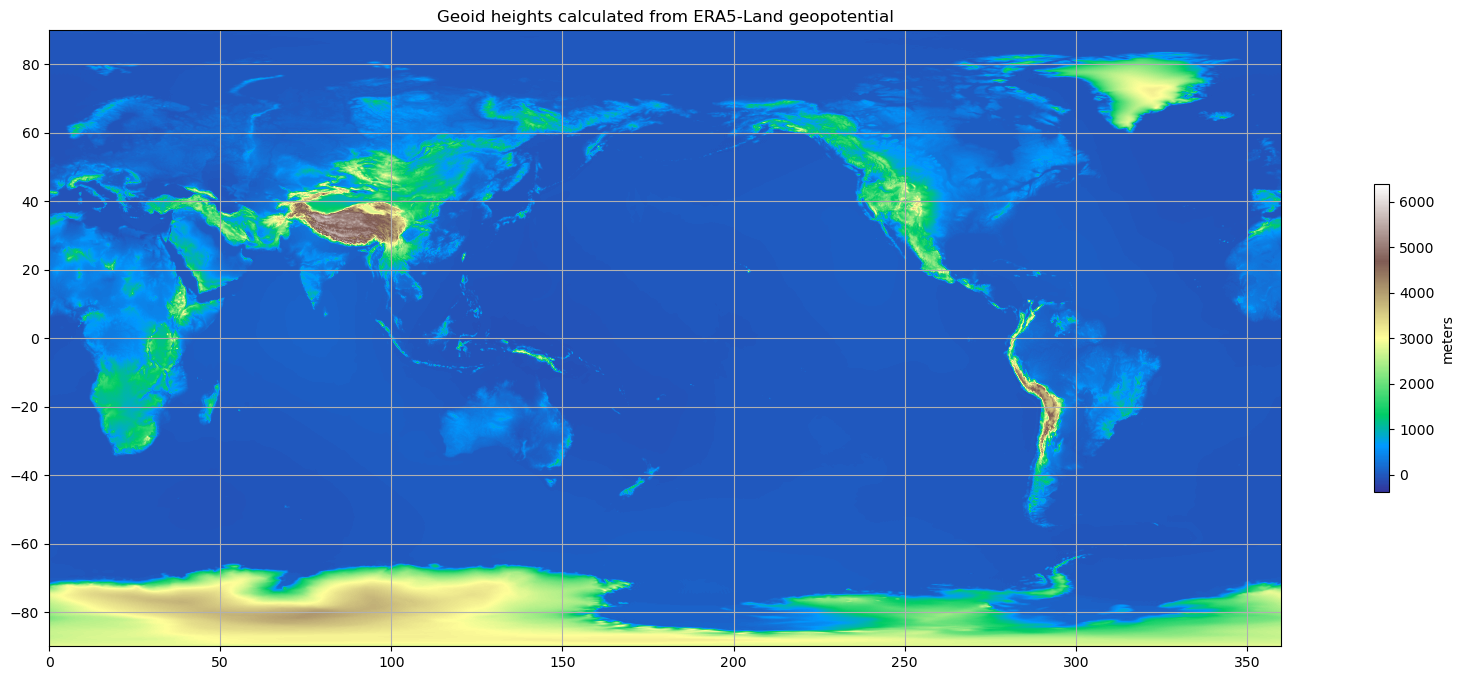

In [6]:
# Load ERA5-Land reference elevation data
era_geo = xr.open_dataset(era_geo_fn)
era_geo = era_geo / 9.8
# shift longitudes > 180 to longitude - 360
era_geo.longitude.data[era_geo.longitude.data > 180] = era_geo.longitude.data[era_geo.longitude.data>180] - 360

# Load EGM96 geoid heights
egm96 = xr.open_dataset(egm96_fn)
# interpolate to era_geo coordinates
egm96_interp = egm96.interp(x=era_geo.longitude, y=era_geo.latitude, method='nearest')

# Subtract the geoid from ERA5-Land ellipsoid heights
era_elevs_geoid = era_geo.z.data - egm96_interp.band_data.data
era_geo['z'] = (('time', 'latitude', 'longitude'), era_elevs_geoid)
era_geo = era_geo.rio.write_crs('EPSG:4326')

# Plot geoid heights
plt.figure(figsize=(24,8))
plt.imshow(era_geo.z.data[0], extent=(0,360,-90,90), cmap='terrain')
plt.title('Geoid heights calculated from ERA5-Land geopotential')
plt.colorbar(label='meters', shrink=0.5)
plt.grid()
plt.show()

## Query GEE for ERA5-Land

In [7]:
# Define function to grab mean band values over the region of interest 
def calculate_mean(image):
    # Select specific bands
    image = image.select(bands)
    # Calculate mean for the selected bands in the AOI
    mean_values = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=1000)
    return image.set(mean_values)

Median site elevation = 1911 m
Median site elevation from ERA5-Land = 1463.96 m
ERA5-Land data variables saved to file: /Users/raineyaberle/Research/PhD/Hubbard/weather/Hubbard_ERA5-Land_2016-01-01_2023-12-01.csv


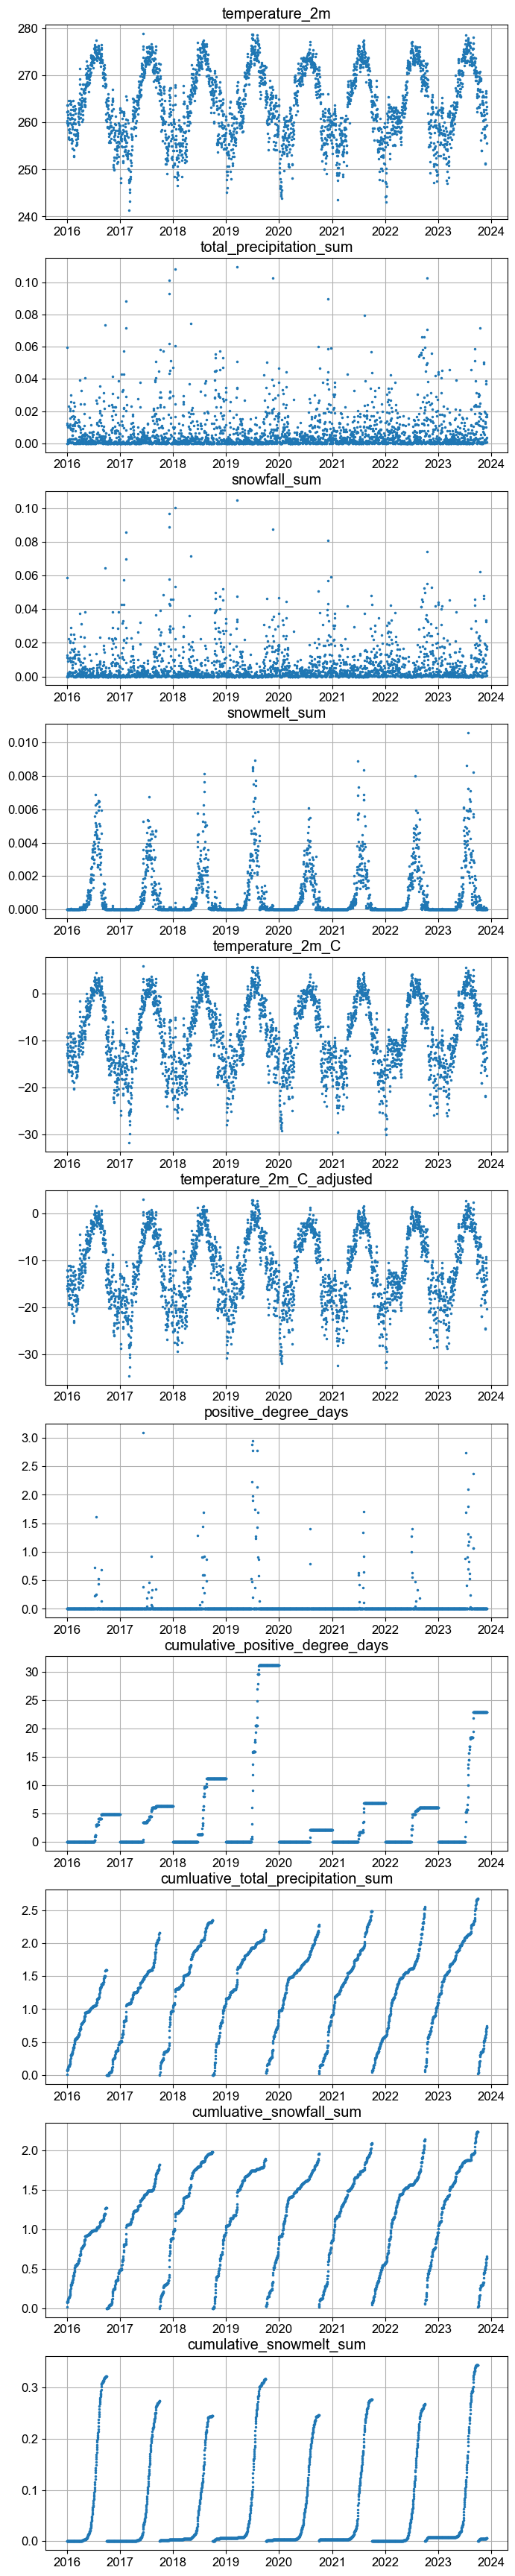

Figure saved to file:  /Users/raineyaberle/Research/PhD/Hubbard/weather/Hubbard_ERA5-Land_2016-01-01_2023-12-01.png


In [8]:
# -----Define lapse rate to apply to air temperatures
lapse_rate = 6 # deg C / km

# -----Make output directory if it does not exist
if not os.path.exists(out_path):
    os.mkdir(out_path)
    print('Made directory for output files')
    
# -----Check if ERA5-Land data already exist in directory
out_fn = os.path.join(out_path, site_name + '_ERA5-Land_' + date_start + '_' + date_end + '.csv')
if not os.path.exists(out_fn):

    # -----Load AOI and reformat for GEE querying
    aoi = gpd.read_file(aoi_fn)
    # reproject to WGS84
    aoi_wgs = aoi.to_crs('EPSG:4326')
    # Reformat to ee.Geometry.Polygon of AOI bounding box
    region = ee.Geometry.Polygon([[[aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.miny[0]],
                                  [aoi_wgs.geometry.bounds.maxx[0], aoi_wgs.geometry.bounds.miny[0]],
                                  [aoi_wgs.geometry.bounds.maxx[0], aoi_wgs.geometry.bounds.maxy[0]],
                                  [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.maxy[0]],
                                  [aoi_wgs.geometry.bounds.minx[0], aoi_wgs.geometry.bounds.miny[0]]
                                  ]])
    
    # -----Load DEM
    dem = xr.open_dataset(dem_fn)
    # reproject to WGS84
    dem = dem.rio.reproject('EPSG:4326')
    # remove no data values
    dem = xr.where((dem > 1e38) or (dem<=-9999), np.nan, dem)
    dem = dem.rio.write_crs('EPSG:4326')

    # -----Grab median elevation over the AOI
    if 'Zmed' in list(aoi.columns): # If using an RGI outline, use the "Zmed" value
        zmed = aoi['Zmed'].values[0]
    else: # Otherwise, use the median value from the DEM
        zmed = np.nanmedian(dem.data)
    print(f'Median site elevation = {np.round(zmed, 2)} m')

    # -----Grab median ERA5-Land elevation over AOI
    # interpolate to DEM coordinates
    era_geo_interp = era_geo.interp(longitude=dem.x, latitude=dem.y, method='linear')
    # clip to AOI
    era_geo_interp_clip = era_geo_interp.rio.clip(aoi_wgs.geometry)
    # calculate median elevation
    elev_med_era = np.nanmedian(np.ravel(era_geo_interp_clip.z.data[0]))
    print(f'Median site elevation from ERA5-Land = {np.round(elev_med_era, 2)} m')
    
    # -----Query GEE for the ERA5-Land dataset
    era5_land = (ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
                 .filter(ee.Filter.date(date_start, date_end))
                 .filterBounds(region))
    
    # -----Calculate mean daily values for all bands
    era5_land_mean = era5_land.map(calculate_mean)
    
    # -----Compile statistics into a pandas.DataFrame
    # ceate empty lists to store the data
    dates = []
    mean_values_list = {band: [] for band in bands}
    # iterate over the ImageCollection to collect data
    for image in era5_land_mean.getInfo()['features']:
        date = pd.to_datetime(image['properties']['system:time_start'], unit='ms')  # Convert to datetime
        dates.append(date)
        mean_values = image['properties']
        for band in bands:
            mean_values_list[band].append(mean_values[band])
    # create a Pandas DataFrame
    data = {'Date': dates}
    data.update(mean_values_list)
    df = pd.DataFrame(data)
    
    # -----Adjust air temperatures for elevation
    if 'temperature_2m' in list(df.columns):
        # Convert air temperatures to Celsius (from Kelvin)
        df['temperature_2m_C'] = df['temperature_2m'] - 273.15
        # Adjust air temperatures using reference elevations and lapse rate
        df['temperature_2m_C_adjusted'] = df['temperature_2m_C'] - lapse_rate * (zmed - elev_med_era)/1e3
    
        # -----Add cumulative positive degree days
        # Calculate Positive Degree Days (PDDs)
        df['positive_degree_days'] = df['temperature_2m_C_adjusted'].apply(lambda x: max(0, x))
        # Calculate cumulative sum and reset at the start of each calendar year
        df['cumulative_positive_degree_days'] = df.groupby(df['Date'].dt.year, group_keys=True)['positive_degree_days'].cumsum()
        # Reset cumulative sum to zero at the start of each year
        df['cumulative_positive_degree_days'] = df.groupby(df['Date'].dt.year, group_keys=False)['cumulative_positive_degree_days'].apply(lambda x: x - x.iloc[0])
    
    # -----Add cumulative annual precipitation, snowfall, and snowmelt
    # Restart the count each water year 
    df['water_year'] = df['Date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1) # add a water year column
    if 'total_precipitation_sum' in list(df.columns):
        df['cumluative_total_precipitation_sum'] = df.groupby('water_year')['total_precipitation_sum'].cumsum()    
    if 'snowfall_sum' in list(df.columns):
        df['cumluative_snowfall_sum'] = df.groupby('water_year')['snowfall_sum'].cumsum()   
    if 'snowmelt_sum' in list(df.columns):
        df['cumulative_snowmelt_sum'] = df.groupby('water_year')['snowmelt_sum'].cumsum()
    
    # -----Save DataFrame to CSV
    df.to_csv(out_fn, index=False)
    print('ERA5-Land data variables saved to file:', out_fn)
    
    # -----Plot data variables
    plot_vars = [x for x in list(df.columns) if (x!='Date') & (x!='water_year')]
    plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
    
    fig, ax = plt.subplots(len(plot_vars), 1, figsize=(8, 4*len(plot_vars)))
    for i, var in enumerate(plot_vars):
        ax[i].plot(df.Date.values.astype('datetime64[ns]'), df[var].values, '.', markersize=3)
        ax[i].set_title(var)
        ax[i].grid()
    plt.show()

    # -----Save figure
    fig_fn = out_fn.replace('.csv', '.png')
    fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
    print('Figure saved to file: ', fig_fn)

else:
    print('ERA5-Land CSV for these dates already exists in file, skipping...')
